In [1]:
import sys
sys.path.append('../modules/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp
from mymodule_2 import *
from mymodule2_2 import *
from pulp_func_2 import *
df2023_result = pd.read_excel('../excels/附件3/2023_result.xlsx')
# 去除列名末尾的空格。很奇怪
df2023_result.columns = [column.rstrip(' ') for column in df2023_result.columns]
# print(df2023_result)

In [2]:
# 数据准备

merged_df = get_merged_df(df21, df22)
# print(merged_df)
total_yield_2023 = merged_df.groupby(['作物编号', '作物名称'])['单地块类型总产量/斤'].sum().reset_index()
total_yield_2023.columns = ['作物编号', '作物名称', '总产量/斤']
# print(total_yield_2023)
expected_sales_data_2023 = total_yield_2023.copy()
expected_sales_data_2023.columns = ['作物编号', '作物名称', '预期销售量/斤']

# 按照 '作物编号' 和 '作物名称' 进行分组，并对 '利润' 进行求和
total_profit = merged_df.groupby(['作物编号', '作物名称'])[['利润', '每亩利润']].sum().reset_index()
# 重命名列，以便清晰地表示数据
total_profit.columns = ['作物编号', '作物名称', '总利润/元', '每亩总利润/元']
# 打印 total_profit
# print(total_profit)
total_profit_2023 = total_profit['总利润/元'].sum()
# print("总利润/元的和:", total_profit_2023)
std_devs = [0.005, 0.005, 0.01, 0.01, 0.003, 0.003, 0.003, 0.003]
past_profits = [total_profit_2023]

fields = create_fields(df11)
# for field in fields:
#     print(field)
new_fields = create_new_fields(fields)
# for field in new_fields:
#     print(field)

### 2 - 2024

In [3]:
mc = 20 # 蒙特卡洛模拟次数
weights = [0.7, 0.3] # 分数计算权重
k = 0.5
min_area_percent = 0.2
max_plots = 4
total_score_max = 0
total_score_i_list = []
scores_max = []
profits_max = []
total_profit_i_list = []
stability_max = []
total_stability_i_list = []
for i in range(mc): 
    # 每次蒙特卡洛模拟都要重新初始化数据
    df_template_list = []
    scores = [total_profit_2023, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的得分
    profits = [total_profit_2023, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的利润
    past_profits = [total_profit_2023] # 别忘了重置这个！其实这个和上面的profits是一样的，但已经这么设定了就不改了
    stabilitys = [0, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的稳定性分数（其实是不稳定性）
    expected_sales_data = total_yield_2023.copy() # 初始值为2023年的数据
    expected_sales_data.columns = ['作物编号', '作物名称', '预期销售量/斤']
    crops = create_crops(df12, df22)
    # 2024年

    # 更新数据
    expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
    crops = update_crops(crops, std_devs)

    variables, binary_variables, actual_sales, excess_yield = create_variables(new_fields, crops)
    # 创建线性规划问题
    prob = pulp.LpProblem("Crop_Planting_Optimization", pulp.LpMaximize)
    # 定义目标函数的各个部分
    profit = define_objective_function(variables, actual_sales, excess_yield, crops, new_fields, k)
    # 将目标函数添加到问题中
    prob += profit
    prob = add_constraints2(prob, variables, binary_variables, actual_sales, excess_yield,
                            crops, new_fields, total_yield_2023, df2023_result, min_area_percent, max_plots)

    # 求解问题
    prob.solve()
    print("Status:", pulp.LpStatus[prob.status])
    update_new_fields(variables, new_fields)
    df_template = pd.read_excel('../excels/附件3/template.xlsx')
    df_template_list.append(update_template(df_template, new_fields))


    objective_value = pulp.value(prob.objective)
    past_profits.append(objective_value)
    print("Objective Value / Profit:", objective_value)
    profits[1] = objective_value

    stability = calculate_stability(past_profits)
    print("Stability:", stability)
    stabilitys[1] = stability

    score_now = calculate_score(objective_value, stability, weights)
    print("Score:", score_now)
    scores[1] = score_now
    # 清空当年的种植信息
    for field in new_fields:
        field.planted_crop = []

    # 2025年到2030年

    for year in range(2025, 2031):
        list = [k, min_area_percent, max_plots, year]
        expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
        crops = update_crops(crops, std_devs)

        df_last1_result = pd.read_excel(f'../excels/附件3/{year - 1}_result_{k}.xlsx')
        df_last1_result.columns = [column.rstrip(' ') for column in df_last1_result.columns]
        if year - 2 == 2023:
            df_last2_result = pd.read_excel(f'../excels/附件3/2023_result.xlsx')
        else:    
            df_last2_result = pd.read_excel(f'../excels/附件3/{year - 2}_result_{k}.xlsx')
        df_last2_result.columns = [column.rstrip(' ') for column in df_last2_result.columns]

        objective_value = optimize_planting_strategy(new_fields, crops, expected_sales_data, df_last1_result, df_last2_result, list)
        df_template_list.append(update_template(df_template, new_fields))
        past_profits.append(objective_value)
        print("Objective Value / Profit:", objective_value)
        profits[year - 2023] = objective_value

        stability = calculate_stability(past_profits)
        print("Stability:", stability)
        stabilitys[year - 2023] = stability

        score_now = calculate_score(objective_value, stability, weights)
        scores[year - 2023] = score_now
        print("Score:", score_now)
        # 清空当年的种植信息
        for field in new_fields:
            field.planted_crop = []
    
    print("\nScores:", scores)
    total_score_i = sum(scores)
    total_score_i_list.append(total_score_i)
    print("Total Score:", total_score_i)
    print("\n")
    total_profit_i = sum(profits)
    total_stability_i = sum(stabilitys)
    total_profit_i_list.append(total_profit_i)
    total_stability_i_list.append(total_stability_i)

    if total_score_i > total_score_max:
        total_score_max = total_score_i
        scores_max = scores
        profits_max = profits
        stability_max = stabilitys
        for template in df_template_list:
            output(template, year, k)

print("Total Score Max:", total_score_max)
print("Total Score i List:", total_score_i_list)
print("Scores Max:", scores_max)
print("Profits Max:", profits_max)
print("Total Profit i List:", total_profit_i_list)
print("Stability Max:", stability_max)
print("Total Stability i List:", total_stability_i_list)

Status: Optimal


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Objective Value / Profit: 8714756.22976178
Stability: 0.0
Score: 6100329.360833245
Status: Infeasible
Objective Function Value: 7192749.610168388
Objective Value / Profit: 7192749.610168388
Stability: 2155207.2996775853
Score: 4388362.537214596
Status: Infeasible
Objective Function Value: 8566567.2230947
Objective Value / Profit: 8566567.2230947
Stability: 1794019.0111071914
Score: 5458391.352834132
Status: Infeasible
Objective Function Value: 9755925.454094673
Objective Value / Profit: 9755925.454094673
Stability: 1559427.431494394
Score: 6361319.588417952
Status: Infeasible
Objective Function Value: 9262387.353578381
Objective Value / Profit: 9262387.353578381
Stability: 1510722.974172275
Score: 6030454.255253184
Status: Infeasible
Objective Function Value: 10075301.823138274
Objective Value / Profit: 10075301.823138274
Stability: 1380163.7310110952
Score: 6638662.156893463
Status: Infeasible
Objective Function Value: 9312739.394262102
Objective Value / Profit: 9312739.394262102
Stab

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8680807.487247135
Objective Value / Profit: 8680807.487247135
Stability: 1378850.3783273324
Score: 5662910.127574795
Status: Infeasible
Objective Function Value: 8652297.03498299
Objective Value / Profit: 8652297.03498299
Stability: 1306376.6892813516
Score: 5664694.917703687
Status: Infeasible
Objective Function Value: 7527068.212813827
Objective Value / Profit: 7527068.212813827
Stability: 1433732.5609005436
Score: 4838827.980699516
Status: Infeasible
Objective Function Value: 10065501.223605338
Objective Value / Profit: 10065501.223605338
Stability: 1541431.607764566
Score: 6583421.374194367
Status: Infeasible
Objective Function Value: 10175665.43862489
Objective Value / Profit: 10175665.43862489
Stability: 1432321.0301740535
Score: 6693269.4979852075
Status: Infeasible
Objective Function Value: 10623500.70304726
Objective Value / Profit: 10623500.70304726
Stability: 1329198.2254556362
Score: 7037691.024496391

Scores: [5926348.25, 607769

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8710602.936589653
Objective Value / Profit: 8710602.936589653
Stability: 1419084.6262925537
Score: 5671696.667724991
Status: Infeasible
Objective Function Value: 2946624.0305537195
Objective Value / Profit: 2946624.0305537195
Stability: 3566861.682564174
Score: 992578.3166183513
Status: Infeasible
Objective Function Value: 9756852.23020638
Objective Value / Profit: 9756852.23020638
Stability: 4578157.659147271
Score: 5456349.263400285
Status: Infeasible
Objective Function Value: 9260007.818043787
Objective Value / Profit: 9260007.818043787
Stability: 4135952.067913861
Score: 5241219.852256493
Status: Infeasible
Objective Function Value: 10223735.911490008
Objective Value / Profit: 10223735.911490008
Stability: 3777212.4454734344
Score: 6023451.4044009745
Status: Infeasible
Objective Function Value: 10817615.081139069
Objective Value / Profit: 10817615.081139069
Stability: 3497281.283076693
Score: 6523146.171874341

Scores: [5926348.25, 61162

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9036917.374561492
Objective Value / Profit: 9036917.374561492
Stability: 1269877.389653178
Score: 5944878.94529709
Status: Infeasible
Objective Function Value: 5875761.501351871
Objective Value / Profit: 5875761.501351871
Stability: 2453232.612777846
Score: 3377063.2671129555
Status: Infeasible
Objective Function Value: 9227073.058758507
Objective Value / Profit: 9227073.058758507
Stability: 2576989.37001052
Score: 5685854.330127798
Status: Infeasible
Objective Function Value: 9377679.252021372
Objective Value / Profit: 9377679.252021372
Stability: 2320669.6450259225
Score: 5868174.582907183
Status: Infeasible
Objective Function Value: 9588293.45951053
Objective Value / Profit: 9588293.45951053
Stability: 2126000.1451073918
Score: 6074005.378125153
Status: Infeasible
Objective Function Value: 10026231.83569403
Objective Value / Profit: 10026231.83569403
Stability: 1969217.8036409903
Score: 6427596.943893524

Scores: [5926348.25, 6126057.1413

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8614626.776660936
Objective Value / Profit: 8614626.776660936
Stability: 1403968.982929279
Score: 5609048.04878387
Status: Infeasible
Objective Function Value: 8700861.58021048
Objective Value / Profit: 8700861.58021048
Stability: 1290625.2012122874
Score: 5703415.545783649
Status: Infeasible
Objective Function Value: 9075941.12990366
Objective Value / Profit: 9075941.12990366
Stability: 1142783.4233970586
Score: 6010323.763913443
Status: Infeasible
Objective Function Value: 9228940.369257681
Objective Value / Profit: 9228940.369257681
Stability: 1053165.2733028831
Score: 6144308.6764895115
Status: Infeasible
Objective Function Value: 9449580.768641016
Objective Value / Profit: 9449580.768641016
Stability: 975280.2470285192
Score: 6322122.463940155
Status: Infeasible
Objective Function Value: 9700875.169460883
Objective Value / Profit: 9700875.169460883
Stability: 910552.9022968004
Score: 6517446.747933578

Scores: [5926348.25, 6072119.54738

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8943403.015206499
Objective Value / Profit: 8943403.015206499
Stability: 1301766.5991299367
Score: 5869852.130905569
Status: Infeasible
Objective Function Value: 8585784.268619455
Objective Value / Profit: 8585784.268619455
Stability: 1379717.3793790669
Score: 5596133.7742198985
Status: Infeasible
Objective Function Value: 8999549.010466868
Objective Value / Profit: 8999549.010466868
Stability: 1212276.163495892
Score: 5936001.45827804
Status: Infeasible
Objective Function Value: 9346046.952735988
Objective Value / Profit: 9346046.952735988
Stability: 1097341.1224731077
Score: 6213030.530173259
Status: Infeasible
Objective Function Value: 10511187.002437081
Objective Value / Profit: 10511187.002437081
Stability: 1017656.5516989025
Score: 7052533.936196285
Status: Infeasible
Objective Function Value: 9660532.209310077
Objective Value / Profit: 9660532.209310077
Stability: 1098622.6378311997
Score: 6432785.755167694

Scores: [5926348.25, 61156

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9022077.625867728
Objective Value / Profit: 9022077.625867728
Stability: 1269334.0249486063
Score: 5934654.130622827
Status: Infeasible
Objective Function Value: 9236622.837199416
Objective Value / Profit: 9236622.837199416
Stability: 1212102.620092997
Score: 6102005.200011692
Status: Infeasible
Objective Function Value: 9175642.676848695
Objective Value / Profit: 9175642.676848695
Stability: 1164523.2476923675
Score: 6073592.899486376
Status: Infeasible
Objective Function Value: 9247905.029877163
Objective Value / Profit: 9247905.029877163
Stability: 1082830.559693162
Score: 6148684.353006066
Status: Infeasible
Objective Function Value: 9743888.589341667
Objective Value / Profit: 9743888.589341667
Stability: 990473.1173865196
Score: 6523580.07732321
Status: Infeasible
Objective Function Value: 9952379.015563222
Objective Value / Profit: 9952379.015563222
Stability: 929136.7276226681
Score: 6687924.292607455

Scores: [5926348.25, 6120482.874

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Objective Value / Profit: 8747604.192763591
Stability: 0.0
Score: 6123322.934934514
Status: Infeasible
Objective Function Value: 8836088.031343946
Objective Value / Profit: 8836088.031343946
Stability: 1366386.052091618
Score: 5775345.806313276
Status: Infeasible
Objective Function Value: 8846976.667337868
Objective Value / Profit: 8846976.667337868
Stability: 1306914.4657817471
Score: 5800809.327401983
Status: Infeasible
Objective Function Value: -3046324.2289775666
Objective Value / Profit: -3046324.2289775666
Stability: 5685306.201147168
Score: -3838018.8206284465
Status: Infeasible
Objective Function Value: 9335486.047997909
Objective Value / Profit: 9335486.047997909
Stability: 7751165.343183282
Score: 4209490.630643551
Status: Infeasible
Objective Function Value: 9485860.812716968
Objective Value / Profit: 9485860.812716968
Stability: 7078584.948998752
Score: 4516527.084202252
Status: Infeasible
Objective Function Value: 9490475.343747064
Objective Value / Profit: 9490475.3437470

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 6881543.894526994
Objective Value / Profit: 6881543.894526994
Stability: 2326957.988810214
Score: 4118993.329525831
Status: Infeasible
Objective Function Value: 9446603.728303961
Objective Value / Profit: 9446603.728303961
Stability: 2139662.3874171725
Score: 5970723.893587621
Status: Infeasible
Objective Function Value: 9153561.069950223
Objective Value / Profit: 9153561.069950223
Stability: 1958784.4845206433
Score: 5819857.403608963
Status: Infeasible
Objective Function Value: 9625538.833809607
Objective Value / Profit: 9625538.833809607
Stability: 1757101.7664333815
Score: 6210746.653736711
Status: Infeasible
Objective Function Value: 10635490.710605148
Objective Value / Profit: 10635490.710605148
Stability: 1607162.836119193
Score: 6962694.646587845
Status: Infeasible
Objective Function Value: 10111664.83667751
Objective Value / Profit: 10111664.83667751
Stability: 1556820.0610923124
Score: 6611119.367346563

Scores: [5926348.25, 611163

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Objective Value / Profit: 8583210.933475204
Stability: 0.0
Score: 6008247.653432642
Status: Infeasible
Objective Function Value: 8707336.452181758
Objective Value / Profit: 8707336.452181758
Stability: 1266368.5823843246
Score: 5715224.941811933
Status: Infeasible
Objective Function Value: 8883830.881275969
Objective Value / Profit: 8883830.881275969
Stability: 1181793.6803349457
Score: 5864143.512792694
Status: Infeasible
Objective Function Value: 9762656.767256938
Objective Value / Profit: 9762656.767256938
Stability: 1024511.5817688724
Score: 6526506.2625491945
Status: Infeasible
Objective Function Value: 9158103.957939627
Objective Value / Profit: 9158103.957939627
Stability: 1109454.5319842666
Score: 6077836.410962458
Status: Infeasible
Objective Function Value: 9574424.11506144
Objective Value / Profit: 9574424.11506144
Stability: 1016410.5145243711
Score: 6397173.726185696
Status: Infeasible
Objective Function Value: 9469003.472404307
Objective Value / Profit: 9469003.472404307


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9056275.640024446
Objective Value / Profit: 9056275.640024446
Stability: 1242870.7530816384
Score: 5966531.72209262
Status: Infeasible
Objective Function Value: 7060471.07709499
Objective Value / Profit: 7060471.07709499
Stability: 1961476.4118083308
Score: 4353886.830423993
Status: Infeasible
Objective Function Value: 8865963.806486113
Objective Value / Profit: 8865963.806486113
Stability: 1807649.2397209222
Score: 5663879.892624002
Status: Infeasible
Objective Function Value: 9337957.013003172
Objective Value / Profit: 9337957.013003172
Stability: 1620227.1888273293
Score: 6050501.752454021
Status: Infeasible
Objective Function Value: 10123487.694770832
Objective Value / Profit: 10123487.694770832
Stability: 1479558.3492470381
Score: 6642573.88156547
Status: Infeasible
Objective Function Value: 9277584.493640827
Objective Value / Profit: 9277584.493640827
Stability: 1472689.885855315
Score: 6052502.179791984

Scores: [5926348.25, 6113927.8

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8827347.214058006
Objective Value / Profit: 8827347.214058006
Stability: 1315352.0353410887
Score: 5784537.439238277
Status: Infeasible
Objective Function Value: 8602500.61695668
Objective Value / Profit: 8602500.61695668
Stability: 1333103.0980789983
Score: 5621819.502445976
Status: Infeasible
Objective Function Value: 9124178.418751594
Objective Value / Profit: 9124178.418751594
Stability: 1165587.1613219087
Score: 6037248.744729542
Status: Infeasible
Objective Function Value: 6934569.056441773
Objective Value / Profit: 6934569.056441773
Stability: 1586315.8884790079
Score: 4378303.572965538
Status: Infeasible
Objective Function Value: 10322155.164971119
Objective Value / Profit: 10322155.164971119
Stability: 1872632.382185695
Score: 6663718.900824075
Status: Infeasible
Objective Function Value: 9700881.214484459
Objective Value / Profit: 9700881.214484459
Stability: 1797288.1723761237
Score: 6251430.398426283

Scores: [5926348.25, 6084539

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8173790.738912896
Objective Value / Profit: 8173790.738912896
Stability: 1627070.418969763
Score: 5233532.391548098
Status: Infeasible
Objective Function Value: 9570131.330559535
Objective Value / Profit: 9570131.330559535
Stability: 1334698.9467726194
Score: 6298682.247359889
Status: Infeasible
Objective Function Value: 9875769.978799578
Objective Value / Profit: 9875769.978799578
Stability: 1221056.3255085635
Score: 6546722.087507135
Status: Infeasible
Objective Function Value: 9136855.698981239
Objective Value / Profit: 9136855.698981239
Stability: 1292123.824961301
Score: 6008161.841798477
Status: Infeasible
Objective Function Value: 10462872.299915083
Objective Value / Profit: 10462872.299915083
Stability: 1206765.8657105688
Score: 6961980.850227387
Status: Infeasible
Objective Function Value: 10803480.431355484
Objective Value / Profit: 10803480.431355484
Stability: 1126668.0127773401
Score: 7224435.898115636

Scores: [5926348.25, 6073

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8650430.696505947
Objective Value / Profit: 8650430.696505947
Stability: 1362936.218658085
Score: 5646420.621956738
Status: Infeasible
Objective Function Value: 9490886.260825513
Objective Value / Profit: 9490886.260825513
Stability: 1139672.175866083
Score: 6301718.729818034
Status: Infeasible
Objective Function Value: 8848041.974208983
Objective Value / Profit: 8848041.974208983
Stability: 1266001.9389649061
Score: 5813828.800256815
Status: Infeasible
Objective Function Value: 9267448.211919064
Objective Value / Profit: 9267448.211919064
Stability: 1139160.1286469921
Score: 6145465.709749246
Status: Infeasible
Objective Function Value: 9418529.550271707
Objective Value / Profit: 9418529.550271707
Stability: 1057614.4001482876
Score: 6275686.365145708
Status: Infeasible
Objective Function Value: 9639932.214851435
Objective Value / Profit: 9639932.214851435
Stability: 987259.0235863834
Score: 6451774.843320089

Scores: [5926348.25, 6055927.9

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9037625.022398038
Objective Value / Profit: 9037625.022398038
Stability: 1236014.161028291
Score: 5955533.267370139
Status: Infeasible
Objective Function Value: 8936155.35065183
Objective Value / Profit: 8936155.35065183
Stability: 1276209.6775211971
Score: 5872445.842199922
Status: Infeasible
Objective Function Value: -95246946.14013761
Objective Value / Profit: -95246946.14013761
Stability: 45560442.111237824
Score: -80340994.93146767
Status: Infeasible
Objective Function Value: 9099148.061998332
Objective Value / Profit: 9099148.061998332
Stability: 65951676.94522376
Score: -13416099.440168295
Status: Infeasible
Objective Function Value: 9022696.818115773
Objective Value / Profit: 9022696.818115773
Stability: 60205951.72712766
Score: -11745897.745457256
Status: Infeasible
Objective Function Value: 8538621.210225243
Objective Value / Profit: 8538621.210225243
Stability: 55740978.91432713
Score: -10745258.827140467

Scores: [5926348.25, 610

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8683062.051352274
Objective Value / Profit: 8683062.051352274
Stability: 1444478.5793775935
Score: 5644799.862133313
Status: Infeasible
Objective Function Value: 8837672.711052872
Objective Value / Profit: 8837672.711052872
Stability: 1312936.4849784363
Score: 5792489.95224348
Status: Infeasible
Objective Function Value: 9194886.913056556
Objective Value / Profit: 9194886.913056556
Stability: 1167630.337272543
Score: 6086131.737957826
Status: Infeasible
Objective Function Value: 9276484.399894841
Objective Value / Profit: 9276484.399894841
Stability: 1085011.9235605232
Score: 6168035.502858232
Status: Infeasible
Objective Function Value: 9436345.478637667
Objective Value / Profit: 9436345.478637667
Stability: 1008558.841689339
Score: 6302874.1825395655
Status: Infeasible
Objective Function Value: 9625576.200501941
Objective Value / Profit: 9625576.200501941
Stability: 943958.4163245399
Score: 6454715.815453996

Scores: [5926348.25, 6124428.6

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: -16302222.430179406
Objective Value / Profit: -16302222.430179406
Stability: 13917661.818301126
Score: -15586854.24661592
Status: Infeasible
Objective Function Value: 9524258.196966428
Objective Value / Profit: 9524258.196966428
Stability: 20793824.519750826
Score: 428833.38195125107
Status: Infeasible
Objective Function Value: 9526644.401650969
Objective Value / Profit: 9526644.401650969
Stability: 18015436.93893152
Score: 1264019.9994762223
Status: Infeasible
Objective Function Value: 9298190.29267166
Objective Value / Profit: 9298190.29267166
Stability: 16119818.442061532
Score: 1672787.6722517023
Status: Infeasible
Objective Function Value: 10249227.898216411
Objective Value / Profit: 10249227.898216411
Stability: 14715674.869726202
Score: 2759757.0678336276
Status: Infeasible
Objective Function Value: 9502709.412012044
Objective Value / Profit: 9502709.412012044
Stability: 13633735.286250206
Score: 2561776.0025333697

Scores: [5926348.2

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8627320.246709432
Objective Value / Profit: 8627320.246709432
Stability: 1431909.667162981
Score: 5609551.272547708
Status: Infeasible
Objective Function Value: 8801040.365583062
Objective Value / Profit: 8801040.365583062
Stability: 1294078.2923125282
Score: 5772504.768214384
Status: Infeasible
Objective Function Value: 9076735.923233366
Objective Value / Profit: 9076735.923233366
Stability: 1159019.688209422
Score: 6006009.239800529
Status: Infeasible
Objective Function Value: 9183311.432464717
Objective Value / Profit: 9183311.432464717
Stability: 1071852.4784992784
Score: 6106762.259175518
Status: Infeasible
Objective Function Value: 9814132.484246315
Objective Value / Profit: 9814132.484246315
Stability: 978493.0025929194
Score: 6576344.838194545
Status: Infeasible
Objective Function Value: 10665001.580489477
Objective Value / Profit: 10665001.580489477
Stability: 908686.6743015578
Score: 7192895.1040521655

Scores: [5926348.25, 6096120

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8983146.198046656
Objective Value / Profit: 8983146.198046656
Stability: 1243620.7577864071
Score: 5915116.111296737
Status: Infeasible
Objective Function Value: 9366543.665573707
Objective Value / Profit: 9366543.665573707
Stability: 1149957.1216615434
Score: 6211593.429403131
Status: Infeasible
Objective Function Value: 9146436.021095708
Objective Value / Profit: 9146436.021095708
Stability: 1158489.5020952257
Score: 6054958.364138427
Status: Infeasible
Objective Function Value: 9103387.626532847
Objective Value / Profit: 9103387.626532847
Stability: 1090299.9902334956
Score: 6045281.341502944
Status: Infeasible
Objective Function Value: -4138673.6240634187
Objective Value / Profit: -4138673.6240634187
Stability: 5266728.292790893
Score: -4477090.024681661
Status: Infeasible
Objective Function Value: 9345442.973575627
Objective Value / Profit: 9345442.973575627
Stability: 7205811.572695971
Score: 4380066.6096941475

Scores: [5926348.25, 60

e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Objective Value / Profit: 8668386.68513235
Stability: 0.0
Score: 6067870.679592645
Status: Infeasible
Objective Function Value: 8700325.705558272
Objective Value / Profit: 8700325.705558272
Stability: 1355049.7073532147
Score: 5683713.081684826
Status: Infeasible
Objective Function Value: 8749065.443623956
Objective Value / Profit: 8749065.443623956
Stability: 1273611.617641664
Score: 5742262.32524427
Status: Infeasible
Objective Function Value: 9661185.825947853
Objective Value / Profit: 9661185.825947853
Stability: 1103050.4413906275
Score: 6431914.945746308
Status: Infeasible
Objective Function Value: 9125631.815775476
Objective Value / Profit: 9125631.815775476
Stability: 1148378.7759837557
Score: 6043428.638247706
Status: Infeasible
Objective Function Value: 9199795.954453979
Objective Value / Profit: 9199795.954453979
Stability: 1069309.9389324284
Score: 6119064.186438057
Status: Infeasible
Objective Function Value: 9454944.537777578
Objective Value / Profit: 9454944.537777578
St

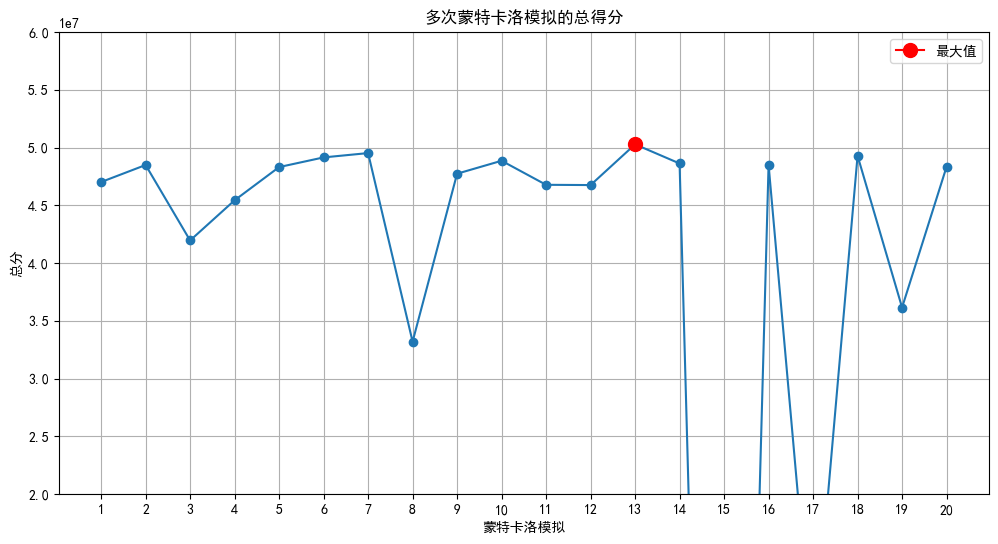

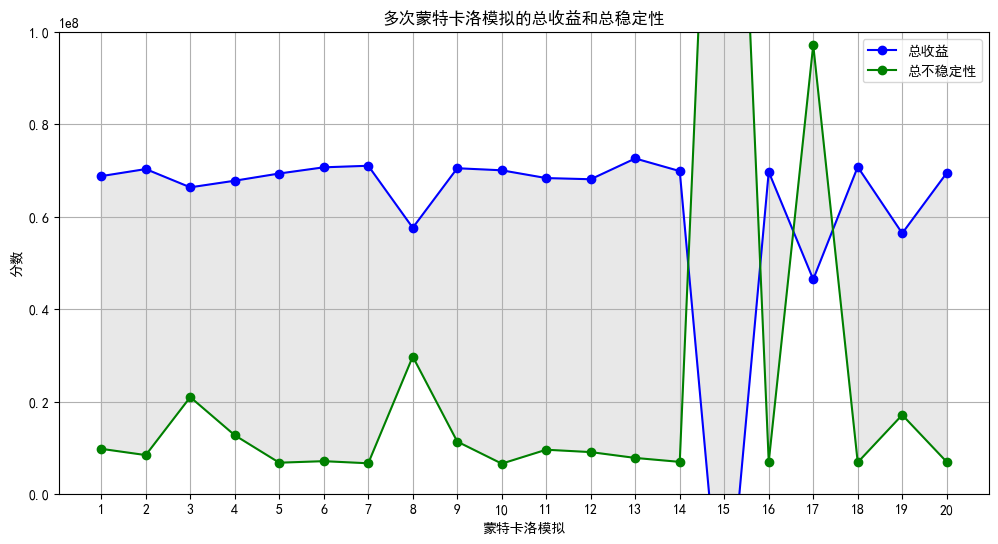

In [11]:
# 定义模拟次数
simulations = [i for i in range(1, mc + 1)]

# 绘制多次蒙特卡洛模拟的总得分折线图
plt.figure(figsize=(12, 6))
plt.plot(simulations, total_score_i_list, marker='o', linestyle='-')

# 找到最大值及其对应的模拟次数
max_score = max(total_score_i_list)
max_index = total_score_i_list.index(max_score)

# 标出最大值点
plt.plot(simulations[max_index], max_score, marker='o', markersize=10, color='red', label='最大值')

plt.title('多次蒙特卡洛模拟的总得分')
plt.xlabel('蒙特卡洛模拟')
plt.xticks(simulations)
plt.ylabel('总分')
plt.ylim(2e7, 6e7)
plt.legend()
plt.grid(True)
plt.show()

# 绘制总利润和总稳定性折线图
plt.figure(figsize=(12, 6))
plt.plot(simulations, total_profit_i_list, label='总收益', color='blue', marker='o', linestyle='-')
plt.plot(simulations, total_stability_i_list, label='总不稳定性', color='green', marker='o', linestyle='-')

# 在两条折线之间填充颜色
plt.fill_between(simulations, total_profit_i_list, total_stability_i_list, color='lightgray', alpha=0.5)

# 添加标题和标签
plt.title('多次蒙特卡洛模拟的总收益和总稳定性')
plt.xlabel('蒙特卡洛模拟')
plt.xticks(simulations)
plt.ylabel('分数')
plt.ylim(0, 1e8)
plt.legend()
plt.grid(True)
plt.show()

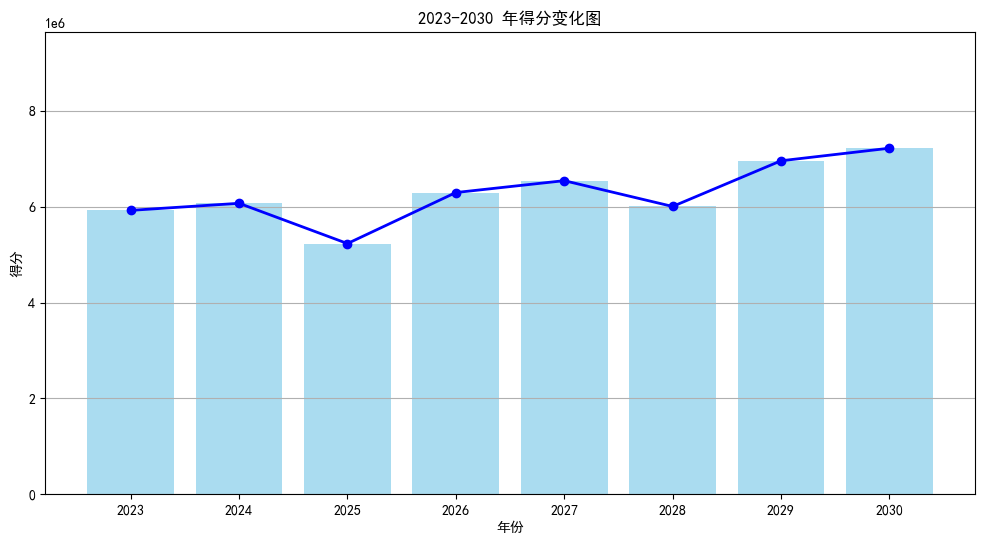

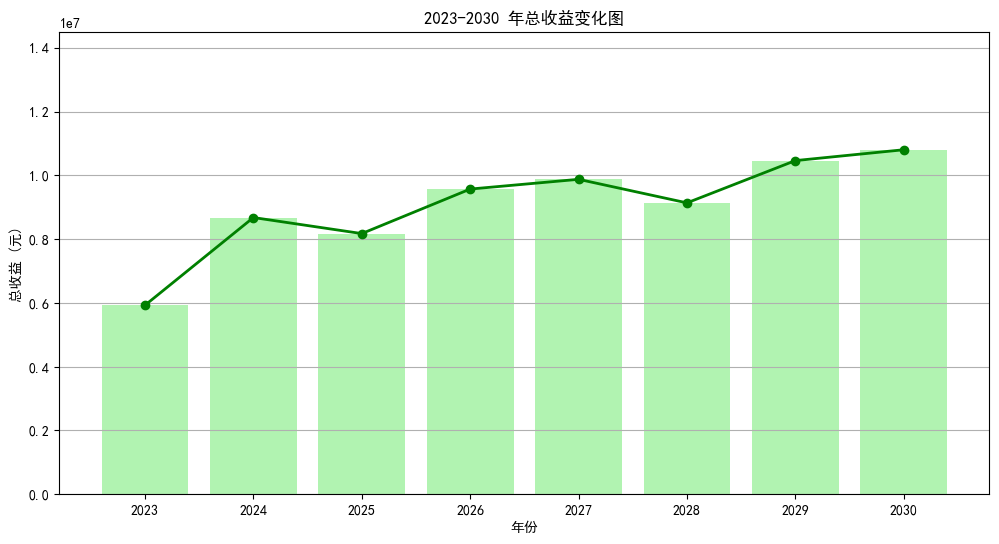

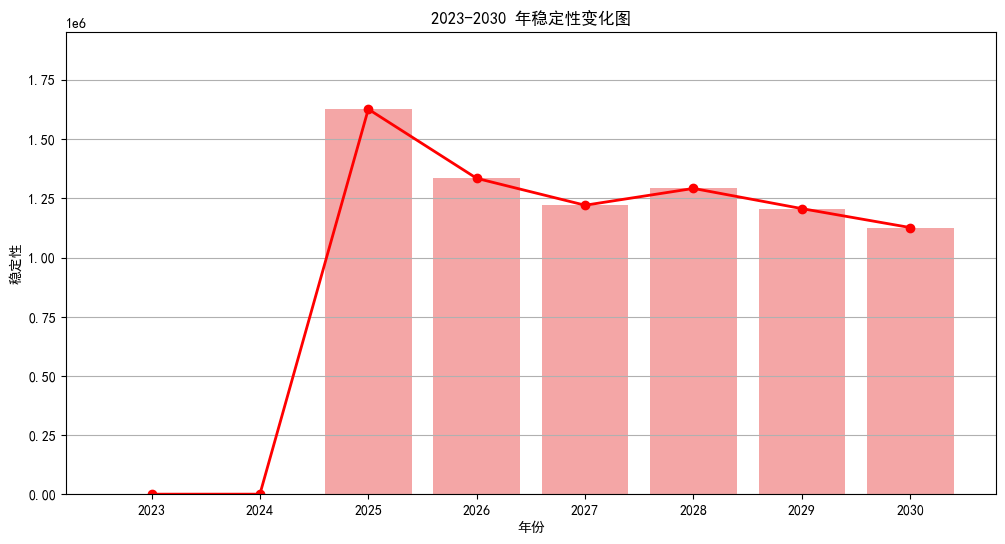

In [5]:
# 定义年份
years = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]

# 绘制得分变化图
plt.figure(figsize=(12, 6))
plt.bar(years, scores_max, color='skyblue', alpha=0.7)
plt.plot(years, scores_max, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年得分变化图')
plt.xlabel('年份')
plt.ylabel('得分')
plt.ylim(0, max(scores) * 1.5)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()

# 绘制总收益变化图
plt.figure(figsize=(12, 6))
plt.bar(years, profits_max, color='lightgreen', alpha=0.7)
plt.plot(years, profits_max, color='green', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年总收益变化图')
plt.xlabel('年份')
plt.ylabel('总收益 (元)')
plt.ylim(0, max(profits) * 1.5)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()

# 绘制稳定性变化图
plt.figure(figsize=(12, 6))
plt.bar(years, stability_max, color='lightcoral', alpha=0.7)
plt.plot(years, stability_max, color='red', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年稳定性变化图')
plt.xlabel('年份')
plt.ylabel('稳定性')
plt.ylim(0, max(stability_max) * 1.2)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()


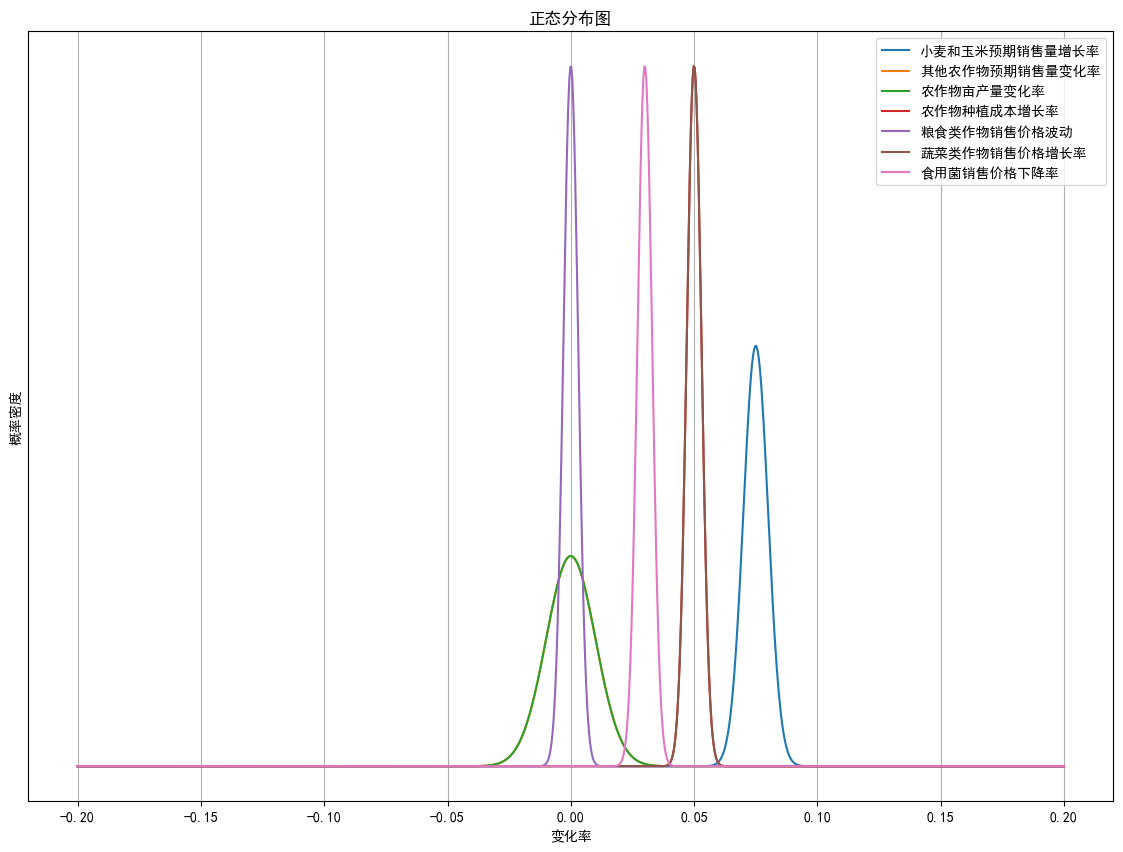

In [6]:
# 定义均值和标准差
data_info = {
    "小麦和玉米预期销售量增长率": {"mean": (0.05 + 0.10) / 2, "std": std_devs[0]},
    "其他农作物预期销售量变化率": {"mean": (0.05 - 0.05) / 2, "std": std_devs[2]},
    "农作物亩产量变化率": {"mean": (0.10 - 0.10) / 2, "std": std_devs[3]},
    "农作物种植成本增长率": {"mean": 0.05, "std": std_devs[4]},
    "粮食类作物销售价格波动": {"mean": 0, "std": std_devs[5]},
    "蔬菜类作物销售价格增长率": {"mean": 0.05, "std": std_devs[6]},
    "食用菌销售价格下降率": {"mean": (0.01 + 0.05) / 2, "std": std_devs[7]}
}

# 生成正态分布数据
x = np.linspace(-0.2, 0.2, 1000)
distributions = {key: (x, np.exp(-((x - value["mean"]) ** 2) / (2 * value["std"] ** 2)) / (value["std"] * np.sqrt(2 * np.pi))) for key, value in data_info.items()}

# 绘制正态分布图
plt.figure(figsize=(14, 10))
for key, (x, y) in distributions.items():
    plt.plot(x, y, label=key)

plt.title("正态分布图")
plt.xlabel("变化率")
plt.ylabel("概率密度")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.show()